In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import pickle
from sklearn.externals import joblib
from sklearn.preprocessing import LabelEncoder

In [2]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
import shap

C:\Users\zagkoui\AppData\Local\conda\conda\envs\irida\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# LOAD TRAINED MODEL AND TEST DATASET

In [27]:
filename = "C:/Users/zagkoui/OneDrive - Vodafone Group/Documents/HIGHER_BUNDLES/models/model.pkl"

In [28]:
loaded_model = joblib.load(filename)

In [29]:
next_dataset = pd.read_csv('C:/Users/zagkoui/OneDrive - Vodafone Group/Documents/HIGHER_BUNDLES/final_data/test/final_customer_db.csv', index_col=0)

In [30]:
next_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273050 entries, 0 to 290135
Columns: 265 entries, MSISDN to MIGRATION
dtypes: float64(240), int64(14), object(11)
memory usage: 554.1+ MB


In [31]:
next_dataset["MIGRATION"].value_counts()

0    247552
1     25498
Name: MIGRATION, dtype: int64

# FUNCTIONS

In [32]:
def split_x_y(df):
    X = df.drop(["MSISDN","MIGRATION", "INSERTED", "CONNECTION_DAY", "Periferiaki_enotita", "Name", "POST_CODE"], axis=1)
    y = df["MIGRATION"].values
    
    return X,y

In [33]:
def encoding_data(X, y):
    le = LabelEncoder()
    objects = X.select_dtypes(include=['object'])
    object_names = list(objects.columns.values)
    
    # Encoding all the categorical columns
    for object_name in object_names:
        if (X[object_name].nunique() > 2):
            enc_pc = pd.get_dummies(X[object_name], drop_first = True)
            X = X.drop(object_name, axis = 1)
            X = pd.concat([X,enc_pc], axis = 1)
        elif (X[object_name].nunique() <= 2):
            le.fit(X[object_name].astype(str))
            X[object_name] = le.transform(X[object_name].astype(str))
    
    # Random forest algorithms -> I don't have to do one-hot encoding
    y = le.fit_transform(y)
    
    return X,y

In [34]:
def estimate_proportion(y):
    count_train_0= (y == 0).sum()
    count_train_1= (y == 1).sum()
    
    proportion = float(count_train_0 / count_train_1)
    
    return proportion

In [35]:
def evaluation(X_test, y_test, classifier):
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    target_names = ['No higher bundle', 'Higher Bundle']
    evaluation_report = classification_report(y_test, y_pred, target_names=target_names)
    
    return cm, accuracy, evaluation_report

In [36]:
def feature_importance(X_test, classifier):
    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, feature_names, plot_type="bar")
    
    shap.summary_plot(shap_values, X_test, feature_names)

# PREPARE DATASET

In [37]:
# Define X and y
X_next, y_next = split_x_y(next_dataset)
# Encoding
X_next, y_next = encoding_data(X_next,y_next)
# Save feature name
feature_names= np.array(X_next.columns)

In [38]:
next_proportion = estimate_proportion(y_next)
print(next_proportion)

9.0


# SCORE - EVALUATION

In [39]:
result = loaded_model.score(X_next, y_next)

C:\Users\zagkoui\AppData\Local\conda\conda\envs\irida\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [40]:
cm, acc, class_report = evaluation(X_next, y_next, loaded_model)
print(cm)
print(acc)
print(class_report)

C:\Users\zagkoui\AppData\Local\conda\conda\envs\irida\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[110830 136722]
 [  3414  22084]]
0.48677531587621314
                  precision    recall  f1-score   support

No higher bundle       0.97      0.45      0.61    247552
   Higher Bundle       0.14      0.87      0.24     25498

     avg / total       0.89      0.49      0.58    273050



# SHAP

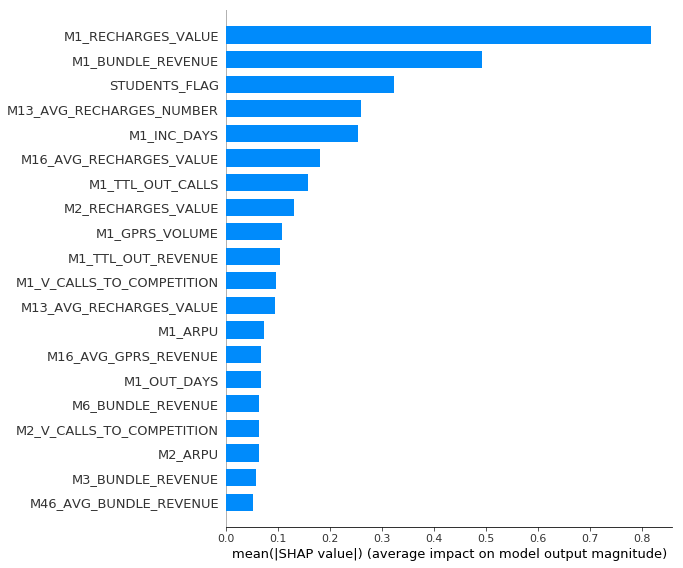

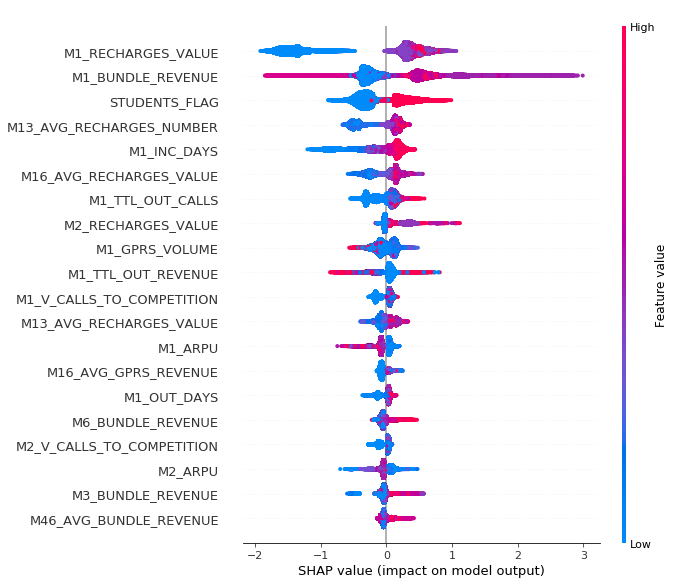

In [32]:
feature_importance(X_next, loaded_model)

In [41]:
pred_y_propab = loaded_model.predict_proba(X_next)
pred_y_propab[:,1]
condition = pred_y_propab[:,1] >= 0.5
len(pred_y_propab[:,1][condition])

158806